In [1]:
from PIL import Image
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import cv2
from sklearn.utils import resample

# Load and preprocess the data
CSV_PATH = "/content/train.csv"
data = pd.read_csv(CSV_PATH)

# Rename columns for clarity
data = data.rename(columns={'ImageId': 'image_name', 'ClassId': 'grade', 'EncodedPixels': 'tags'})

# Create image paths
data['image_path'] = data['image_name'].apply(lambda x: f"/content/drive/MyDrive/Colab Notebooks/yolo-dataset/train_images/crazing_100.jpg")

# Convert grade to integer
data['grade'] = data['grade'].astype(int)

# Separate the dataset by grades
grade_1 = data[data['grade'] == 1]
grade_2 = data[data['grade'] == 2]
grade_3 = data[data['grade'] == 3]
grade_4 = data[data['grade'] == 4]

# Downsample grade 3 to 800 samples
grade_3_downsampled = resample(grade_3, n_samples=800, random_state=42)

# Combine the balanced dataset
balanced_data = pd.concat([grade_1, grade_2, grade_3_downsampled, grade_4])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Function to generate masks using the given tags and image path
def mask_generator(tags, image_path):
    en_pix = tags.split()
    rle = list(map(int, en_pix))
    pixel = [rle[i] for i in range(0, len(rle), 2)]
    pixel_count = [rle[i] for i in range(1, len(rle), 2)]

    # Generate RLE pixels
    rle_pixels = [list(range(pixel[i], pixel[i] + pixel_count[i])) for i in range(len(pixel))]
    rle_mask_pixels = sum(rle_pixels, [])

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")

    # Get image dimensions
    l, b, _ = img.shape
    max_index = l * b - 1
    rle_mask_pixels = [min(pixel, max_index) for pixel in rle_mask_pixels]
    mask_img = np.zeros((l * b,), dtype=np.uint8)

    # Set pixels of interest to 1
    mask_img[rle_mask_pixels] = 1

    mask = mask_img.reshape((b, l)).T

    # Resize the mask to the desired size
    new_size = (625, 100)
    resized_array = cv2.resize(mask, new_size)

    return resized_array

# Create train_x and train_y
train_x = np.array([
    mask_generator(tags, image_path)
    for tags, image_path in zip(balanced_data['tags'], balanced_data['image_path'])
])
train_y = np.array(balanced_data['grade'])

# Print the distribution of grades
print("Distribution of grades:")
print(balanced_data['grade'].value_counts().sort_index())


Distribution of grades:
grade
1      3
3    800
Name: count, dtype: int64


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the input shape
input_shape = (100, 625, 1)  # Mask size (100, 625) with a single channel (grayscale)

# Build the CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output from the convolutional layers
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),

    # Output layer with 4 units (one for each class) and softmax activation
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 623, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 311, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 309, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 154, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 226688)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      29,016,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,035,524 (110.76 MB)

 Trainable params: 29,035,524 (110.76 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Adjust the labels to start from 0 instead of 1
train_y = train_y - 1

# Clip the labels to be within the valid range [0, 3]
train_y = np.clip(train_y, 0, 3)

# Now split the data into training and validation sets (e.g., 80-20 split)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.5247 - loss: 6.5946 - val_accuracy: 1.0000 - val_loss: 1.1610e-05
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 1.0000 - loss: 2.9929e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 751ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       803

    accuracy                           1.00       803
   macro avg       1.00      1.00      1.00       803
weighted avg       1.00      1.00      1.00       803



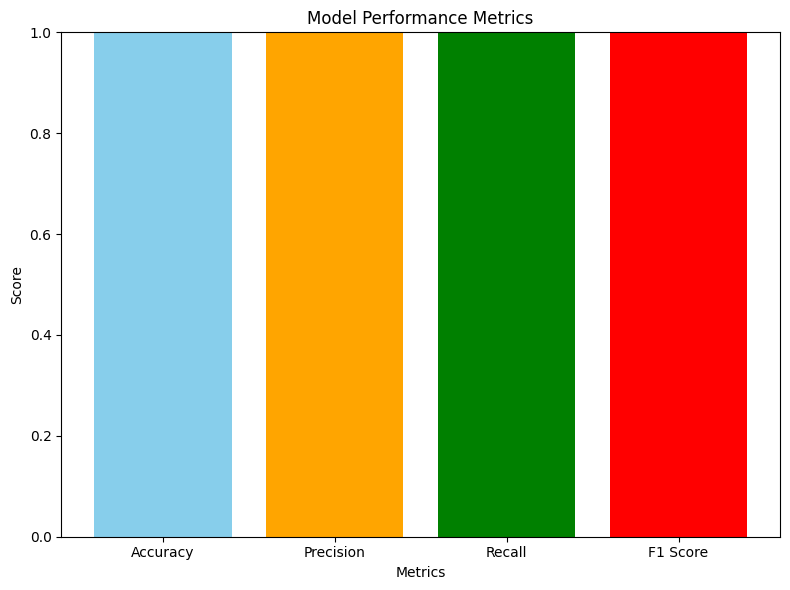

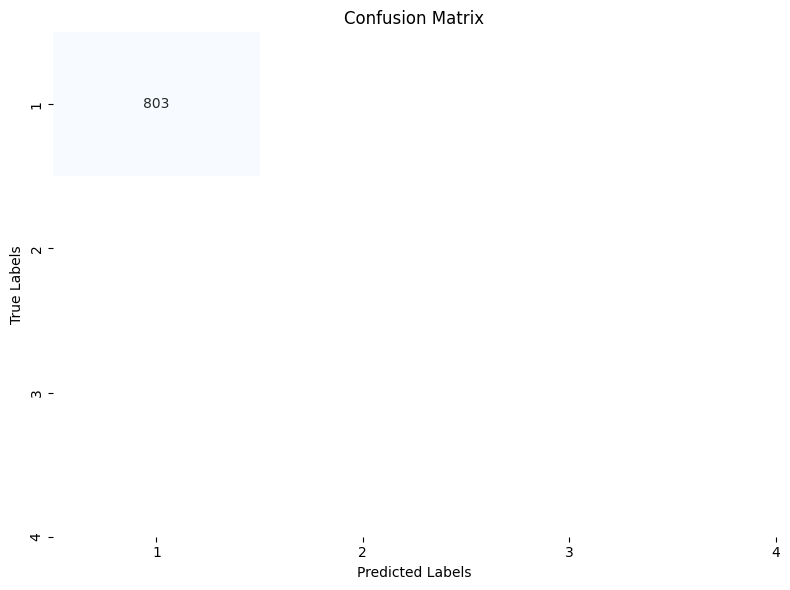

In [9]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

# Select a sample size less than or equal to the length of train_x
sample_size = min(1000, len(train_x))  # Use min to ensure sample size is not larger than population

# Select random images from the dataset
random_indices = random.sample(range(len(train_x)), sample_size)
test_x = train_x[random_indices]
test_y = train_y[random_indices]

# Run predictions
predictions = model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_y, predicted_classes)
recall = recall_score(test_y, predicted_classes, average='macro')
precision = precision_score(test_y, predicted_classes, average='macro')
f1 = f1_score(test_y, predicted_classes, average='macro')
conf_matrix = confusion_matrix(test_y, predicted_classes)

# Print Classification Report for reference
print("\nClassification Report:\n", classification_report(test_y, predicted_classes))

# Create a bar plot for accuracy, precision, recall, and F1 score
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

# Create a figure and axis for the bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Ensure y-axis goes from 0 to 1 for better comparison
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

<ipython-input-10-c443f046a258>:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


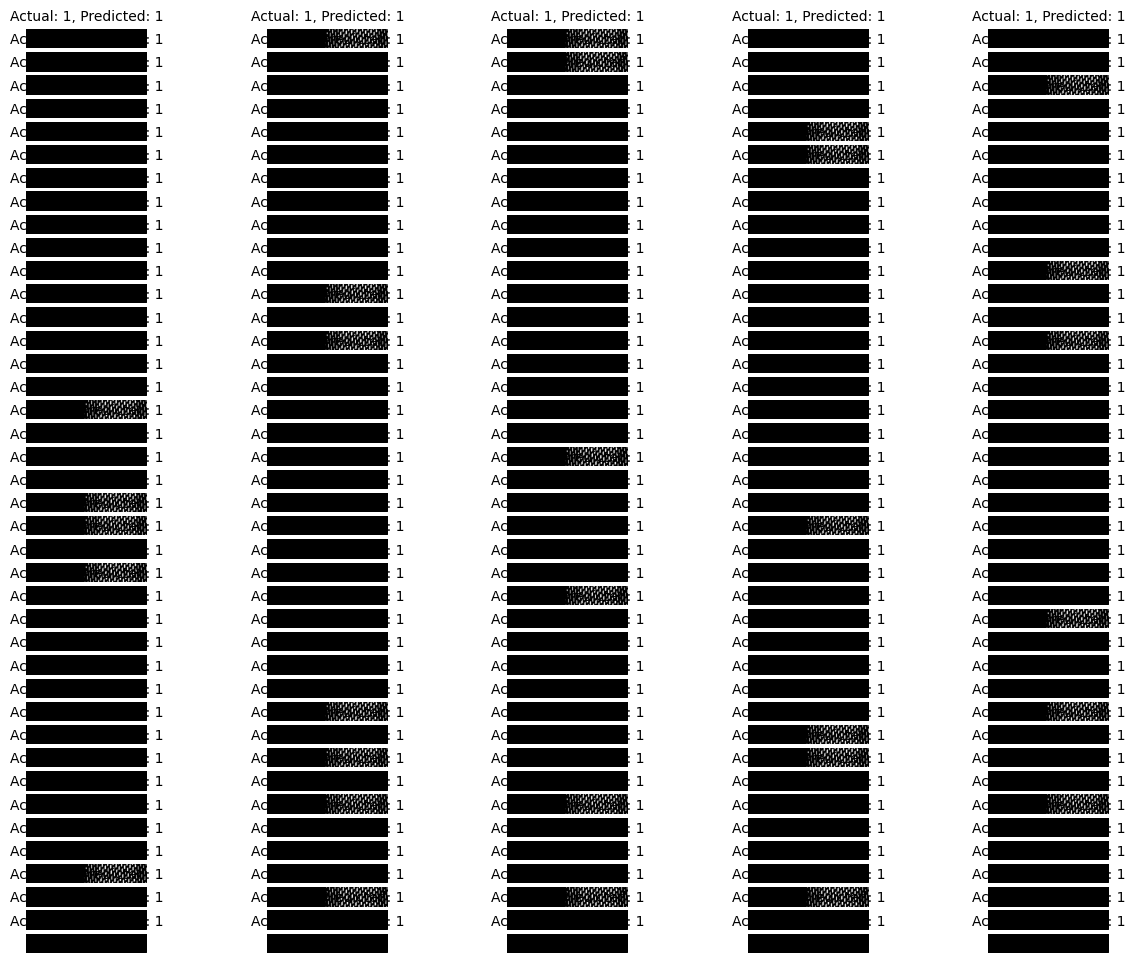

In [10]:
import matplotlib.pyplot as plt

# Plot a table of images, actual grades, and predicted grades
def plot_images_with_labels(images, actual_labels, predicted_labels, rows=4, cols=5):
    fig, axs = plt.subplots(rows, cols, figsize=(15, 12))

    for i in range(rows * cols):
        ax = axs[i // cols, i % cols]

        # Display the image
        ax.imshow(images[i].reshape(100, 625), cmap='gray')

        # Title shows actual vs predicted grades
        ax.set_title(f'Actual: {actual_labels[i]+1}, Predicted: {predicted_labels[i]+1}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display 20 random images with actual and predicted grades
plot_images_with_labels(test_x, test_y, predicted_classes, rows=40, cols=5)


In [11]:
model.save('cnn_model_mask.h5')
